In [78]:
import openface
from keras.models import load_model
from keras.utils import CustomObjectScope
from keras import optimizers
import keras
from keras.layers import Input, Activation, Dropout, Dense
from keras.models import Model
from keras.callbacks import EarlyStopping
import tensorflow as tf
import numpy as np
import cv2
import dlib
import time
from keras import backend as K
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [55]:
with CustomObjectScope({'tf': tf}):
    model = load_model('./nn4.small2.v1.h5')


KeyboardInterrupt: 

In [ ]:
print model.summary()

In [39]:
type(model.layers[163].output)

tensorflow.python.framework.ops.Tensor

In [48]:
get_flatten_layer_output = K.function([model.layers[0].input], [model.layers[163].output])
# start = time.time()
img1 = cv2.imread('/Users/ketanagrawal/Desktop/image-test/parkerface.jpeg', 1)
bb = detect_largest_face2(img1)
#     x, y, w, h = detect_largest_face(img1)
# print "Face detection took %s secs" % (time.time() - start)

# start = time.time()
#     cv2.imshow('largest face', img1[y:y+h, x:x+w])
#     cv2.waitKey()
#     if img_to_encoding.align is None:

In [68]:
def process_image(img1):
    bb = dlib.rectangle(0, 0, 96, 96)
    img1 = img_to_encoding.align.align(96, img1, bb, landmarkIndices=openface.AlignDlib.OUTER_EYES_AND_NOSE)
    img = img1[...,::-1]
    img = np.around(img/255.0, decimals=12)
    img = np.array([img])
    return img

In [74]:
def do_it():
    X_data, Y_data, _, _, _ = np.load('data.npy')
    print "processing images"
    X_data = [process_image(x) for x in X_data]
    print "getting intermediate layer"
    intermediate_output = [get_flatten_layer_output([x]) for x in X_data]
    return intermediate_output, Y_data

In [75]:
def coolModel(input_shape):
    X_input = Input(input_shape)
    model = Dense(256)(X_input)
    model = Activation('relu')(model)
    model = Dropout(0.5)(model)
    model = Dense(64, activation='relu')(model)
    model = Dropout(0.5)(model)
    model = Dense(16, activation='relu')(model)
    model = Dropout(0.125)(model) 
    model = Dense(1, activation='sigmoid')(model)
    model = Model(inputs=X_input, outputs=model, name='cool model')
    return model

In [76]:
def shuffle(x, y): 
    state = np.random.get_state()
    np.random.shuffle(x)
    np.random.set_state(state)
    np.random.shuffle(y)

def finishData(X_data, Y_data): 
    print "shuffling"
    shuffle(X_data, Y_data)
    print "splitting"
    return train_test_split(X_data, Y_data, test_size=.10)

In [106]:
X_train = np.array(X_train)
print X_train.shape

(27757, 736)


In [107]:
Y_train = np.array(Y_train)
print Y_train.shape

(27757,)


In [110]:
X_test = np.array([x[0][0] for x in X_test])
Y_test = np.array([x[0] for x in Y_test])
print X_test.shape
print Y_test.shape

(3085, 736)
(3085,)


Train on 23593 samples, validate on 4164 samples
Epoch 1/10
23593/23593 [==============================] - 7s 305us/step - loss: 0.3080 - acc: 0.8556 - val_loss: 0.2716 - val_acc: 0.8854
Epoch 2/10
23593/23593 [==============================] - 8s 320us/step - loss: 0.3071 - acc: 0.8602 - val_loss: 0.2585 - val_acc: 0.8963
Epoch 3/10
23593/23593 [==============================] - 8s 320us/step - loss: 0.3056 - acc: 0.8600 - val_loss: 0.2768 - val_acc: 0.8787
Epoch 4/10
23593/23593 [==============================] - 7s 277us/step - loss: 0.3013 - acc: 0.8620 - val_loss: 0.2710 - val_acc: 0.8845
Epoch 5/10
23593/23593 [==============================] - 6s 257us/step - loss: 0.3029 - acc: 0.8603 - val_loss: 0.2601 - val_acc: 0.8905
Epoch 6/10
23593/23593 [==============================] - 7s 294us/step - loss: 0.2998 - acc: 0.8627 - val_loss: 0.2582 - val_acc: 0.8958
Epoch 7/10
23593/23593 [==============================] - 7s 294us/step - loss: 0.2897 - acc: 0.8659 - val_loss: 0.2498 - v

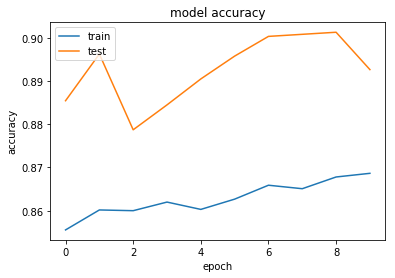

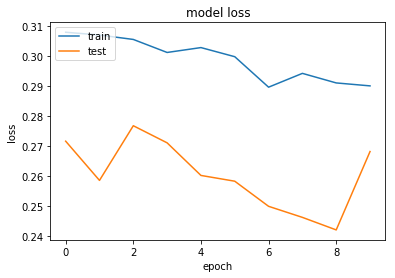

3085/3085 [==============================] - 0s 100us/step
[0.277690371151295, 0.8790923825152689]


In [112]:
# cool = coolModel((736,))
# cool.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# X_data, Y_data = do_it()
# X_train, X_test, Y_train, Y_test = finishData(X_data, Y_data)
# print "finished data"
cb = [EarlyStopping(monitor='val loss', min_delta=0, patience=1)]
simple_history = cool.fit(X_train, Y_train, batch_size=32, epochs=10, validation_split=.15, callbacks=cb, verbose=1)
print(simple_history.history.keys())
plt.plot(simple_history.history['acc'])
plt.plot(simple_history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(simple_history.history['loss'])
plt.plot(simple_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
test_performance = cool.evaluate(X_test, Y_test)
print test_performance

In [113]:
cool.save('cool.h5')

In [25]:
#from https://github.com/obieda01/Deep-Learning-Specialization-Coursera/blob/master/Course%204%20-%20Convolutional%20Neural%20Networks/Week%204/Face%20Recognition/Face%20Recognition%20for%20the%20Happy%20House%20-%20%20v1.ipynb
def triplet_loss(y_true, y_pred, alpha = 0.2):
    """
    Implementation of the triplet loss as defined by formula (3)
    
    Arguments:
    y_true -- true labels, required when you define a loss in Keras, you don't need it in this function.
    y_pred -- python list containing three objects:
            anchor -- the encodings for the anchor images, of shape (None, 128)
            positive -- the encodings for the positive images, of shape (None, 128)
            negative -- the encodings for the negative images, of shape (None, 128)
    
    Returns:
    loss -- real number, value of the loss
    """
    
    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]
    
    ### START CODE HERE ### (≈ 4 lines)
    # Step 1: Compute the (encoding) distance between the anchor and the positive
    pos_dist = tf.reduce_sum(tf.squared_difference(anchor, positive))
    # Step 2: Compute the (encoding) distance between the anchor and the negative
    neg_dist = tf.reduce_sum(tf.squared_difference(anchor, negative))
    # Step 3: subtract the two previous distances and add alpha.
    basic_loss = pos_dist - neg_dist + alpha
    # Step 4: Take the maximum of basic_loss and 0.0. Sum over the training examples.
    maxi = tf.maximum(basic_loss, 0.0)
    loss = tf.reduce_sum(tf.maximum(basic_loss, 0.0))
    ### END CODE HERE ###
    
    return loss

In [10]:
adam= keras.optimizers.Adam()
model.compile(optimizer='adam', loss=triplet_loss, metrics = ['accuracy'])

In [24]:
def img_to_encoding(img_path, model):
    start = time.time()
    img1 = cv2.imread(img_path, 1)
    bb = detect_largest_face2(img1)
#     x, y, w, h = detect_largest_face(img1)
    print "Face detection took %s secs" % (time.time() - start)
    
    start = time.time()
#     cv2.imshow('largest face', img1[y:y+h, x:x+w])
#     cv2.waitKey()
#     if img_to_encoding.align is None:
#         facePredictor = '/Users/ketanagrawal/openface/models/dlib/shape_predictor_68_face_landmarks.dat'
#         img_to_encoding.align = openface.AlignDlib(facePredictor)
#     print "Face alignment part 1 took %s secs" % (time.time() - start)
#     s = time.time()
#     bb = dlib.rectangle(x, y, x + w, y + h)
    img1 = img_to_encoding.align.align(96, img1, bb, landmarkIndices=openface.AlignDlib.OUTER_EYES_AND_NOSE)
#     print "Face alignment part 2 took %s secs" % (time.time() - s)
    print "Face alignment took %s secs" % (time.time() - start)
    
    start = time.time()
    img = img1[...,::-1]
    img = np.around(img/255.0, decimals=12)
    x_train = np.array([img])
    embedding = model.predict_on_batch(x_train)
    print "Forward pass took %s secs" % (time.time() - start)
    return embedding

facePredictor = '/Users/ketanagrawal/openface/models/dlib/shape_predictor_68_face_landmarks.dat'
img_to_encoding.align = openface.AlignDlib(facePredictor)

def detect_largest_face2(img):
    return img_to_encoding.align.getLargestFaceBoundingBox(img)

def detect_largest_face(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    face_boxes = detect_largest_face.face_cascade.detectMultiScale(gray, 1.3, 5)
    face_areas = [w*h for x, y, w, h in face_boxes]
    x, y, w, h = face_boxes[face_areas.index(max(face_areas))]
    return dlib.rectangle(x, y, x + w, y + h)

detect_largest_face.face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

# def get_cropped_face(img_path):
#     img = cv2.imread(img_path, 1)
#     #TODO: take out manual resizing completely
#     #
#     face_box = detect_largest_face(img)
#     img_cropped = img[y:y+h, x:x+w]
#     img_cropped = cv2.resize(img_cropped, (96, 96))
#     cv2.imshow('cropped', img_cropped)
#     cv2.waitKey()
#     return img_cropped, face_box

In [34]:
database = {}
database['ketan'] = img_to_encoding('/Users/ketanagrawal/Desktop/image-test/ketan-1.jpg', model)
database['sid'] = img_to_encoding('/Users/ketanagrawal/Desktop/image-test/sid-1.jpeg', model)
database['parker'] = img_to_encoding('/Users/ketanagrawal/Desktop/image-test/parkerface.jpeg', model)
database['aditya'] = img_to_encoding('/Users/ketanagrawal/Desktop/image-test/aditya-1.jpg', model)
database['aditya'] = img_to_encoding('/Users/ketanagrawal/Desktop/image-test/aditya-1.jpg', model)
database['aditya'] = img_to_encoding('/Users/ketanagrawal/Desktop/image-test/aditya-1.jpg', model)
database['aditya'] = img_to_encoding('/Users/ketanagrawal/Desktop/image-test/aditya-1.jpg', model)
database['aditya'] = img_to_encoding('/Users/ketanagrawal/Desktop/image-test/aditya-1.jpg', model)

Face detection took 0.706151008606 secs
Face alignment took 0.00460696220398 secs
Forward pass took 0.0373001098633 secs
Face detection took 0.254812002182 secs
Face alignment took 0.00440788269043 secs
Forward pass took 0.0595650672913 secs
Face detection took 0.247279882431 secs
Face alignment took 0.00497007369995 secs
Forward pass took 0.0427491664886 secs
Face detection took 0.0450839996338 secs
Face alignment took 0.00463008880615 secs
Forward pass took 0.0341148376465 secs
Face detection took 0.0283031463623 secs
Face alignment took 0.00390481948853 secs
Forward pass took 0.0355129241943 secs
Face detection took 0.0275769233704 secs
Face alignment took 0.00397205352783 secs
Forward pass took 0.0435268878937 secs
Face detection took 0.028028011322 secs
Face alignment took 0.00429391860962 secs
Forward pass took 0.0337491035461 secs
Face detection took 0.0275950431824 secs
Face alignment took 0.00384593009949 secs
Forward pass took 0.0322489738464 secs


In [26]:
print database['ketan']

[[-0.11695807  0.0479257  -0.02169226  0.08518837  0.03476244  0.1282892
  -0.0044486  -0.226699    0.14711022 -0.04599588 -0.02680009  0.07860252
  -0.0890829   0.04648315 -0.07148203  0.00265849 -0.070216    0.07054456
  -0.00763653 -0.10913508  0.008445   -0.03583751 -0.05542693  0.14082219
   0.09315073 -0.03337851 -0.10274325 -0.01445491 -0.00047704  0.05960917
   0.17783956  0.06275218 -0.08754221 -0.07426174  0.02352531  0.11968327
  -0.12123275 -0.10547408 -0.0139121   0.07404707  0.07273468  0.0941164
   0.00544526 -0.03143573  0.0590634  -0.13778393  0.02667193 -0.00500333
   0.08644373 -0.0814798  -0.02033384 -0.04388687  0.10945784 -0.10921692
   0.03982809  0.13877183 -0.06106444  0.24127991 -0.01309673 -0.00177161
  -0.11365721  0.14090435  0.14560008 -0.13199224  0.06219028  0.10357567
   0.04821612 -0.08780783 -0.15268555  0.15043259  0.05257808  0.15013172
   0.02377413  0.07691078  0.00340313  0.02818717 -0.03454704 -0.09512714
  -0.10596297 -0.10750516  0.01972636  0

In [27]:

# GRADED FUNCTION: who_is_it# GRADED 

def who_is_it(image_path, database, model):
    """
    Implements face recognition for the happy house by finding who is the person on the image_path image.
    
    Arguments:
    image_path -- path to an image
    database -- database containing image encodings along with the name of the person on the image
    model -- your Inception model instance in Keras
    
    Returns:
    min_dist -- the minimum distance between image_path encoding and the encodings from the database
    identity -- string, the name prediction for the person on image_path
    """
    
    ### START CODE HERE ### 
    
    ## Step 1: Compute the target "encoding" for the image. Use img_to_encoding() see example above. ## (≈ 1 line)
    encoding = img_to_encoding(image_path, model)
    
    start = time.time()
    ## Step 2: Find the closest encoding ##
    
    # Initialize "min_dist" to a large value, say 100 (≈1 line)
    min_dist = 100
    
    # Loop over the database dictionary's names and encodings.
    for (name, db_enc) in database.items():
        
        # Compute L2 distance between the target "encoding" and the current "emb" from the database. (≈ 1 line)
        dist = np.linalg.norm(db_enc - encoding, ord=2)
        print "distance from photo to %s is %s" % (name, dist)
        # If this distance is less than the min_dist, then set min_dist to dist, and identity to name. (≈ 3 lines)
        if dist < min_dist:
            min_dist = dist
            identity = name

    ### END CODE HERE ###
    
    if min_dist > 0.7:
        print("Not in the database.")
    else:
        print ("it's " + str(identity) + ", the distance is " + str(min_dist))
    print "Face identification took %s secs" % (time.time() - start)    
    return min_dist, identity

In [28]:
start = time.time()
who_is_it('/Users/ketanagrawal/Desktop/image-test/ketan-2.jpg', database, model)
# who_is_it('/Users/ketanagrawal/Desktop/image-test/ketan-5.jpg', database, model)
end = time.time()
print "Total time taken: %s" % (end - start)

Face detection took 0.690312862396 secs
Face alignment took 0.00521802902222 secs
Forward pass took 0.0354208946228 secs
distance from photo to ketan is 0.5048104
distance from photo to parker is 1.482557
distance from photo to aditya is 1.0712059
distance from photo to sid is 0.83026433
it's ketan, the distance is 0.5048104
Face identification took 0.00132703781128 secs
Total time taken: 0.736959934235
